### What is DCT (discrete cosine transformation) ?

- This notebook creates arbitrary consumption functions at both 1-dimensional and 2-dimensional grids and illustrate how DCT approximates the full-grid function with different level of accuracies. 
- This is used in [DCT-Copula-Illustration notebook](DCT-Copula-Illustration.ipynb) to plot consumption functions approximated by DCT versus original consumption function at full grids.
- Written by Tao Wang
- June 19, 2019 (Modified on Oct, 2021)

In [3]:
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline') 
else:
    get_ipython().run_line_magic('matplotlib', 'auto') 

In [4]:
import scipy.fftpack as sf  # scipy discrete fourier transform
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as lag
from scipy import misc 
from matplotlib import cm

## DCT in 1 dimension


In [5]:
## make a fake consumption function 

grids= np.linspace(0,100,100)   # this represents the grids on which consumption function is defined.i.e. m or k
c = grids + 50*np.cos(grids*2*np.pi/40)  # this is an arbitrary example of consumption function 

## Do the DCT 
c_dct = sf.dct(c,norm='ortho') # set norm =ortho is important 
ind=np.argsort(abs(c_dct))[::-1]   # get indices of dct coefficients(abosolute value) in the decending order

For accuracy level of 0.5, 1 basis functions used
For accuracy level of 0.95, 3 basis functions used
For accuracy level of 0.99, 3 basis functions used


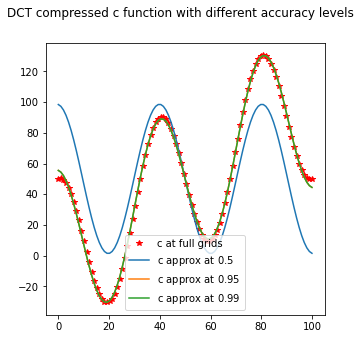

In [6]:
## DCT in 1 dimension for difference accuracy levels

lvl_lst = np.array([0.5,0.95,0.99])

fig = plt.figure(figsize=(5,5))
fig.suptitle('DCT compressed c function with different accuracy levels')

plt.plot(grids,c,'r*',label='c at full grids')

for idx,lvl in enumerate(lvl_lst):
    i = 1 # starts the loop that finds the needed indices so that an target level of approximation is achieved 
    while lag.norm(c_dct[ind[0:i]].copy())/lag.norm(c_dct) < lvl:
        i = i + 1
    needed = i
    print("For accuracy level of "+str(lvl)+", "+str(needed)+" basis functions used")
    c_dct_rdc = c_dct.copy()
    c_dct_rdc[ind[needed+1:]] = 0.0
    c_approx = sf.idct(c_dct_rdc,
                       norm='ortho')  ## norm='ortho' is very important 
    plt.plot(grids,c_approx,label=r'c approx at ${}$'.format(lvl))
plt.legend(loc=0)

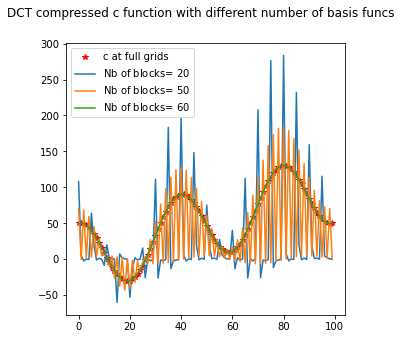

In [7]:
## Blockwise DCT. For illustration but not used in BayerLuetticke. 
## But it illustrates how doing dct in more finely devided blocks give a better approximation

size = c.shape
c_dct = np.zeros(size)
c_approx=np.zeros(size)

fig = plt.figure(figsize=(5,5))
fig.suptitle('DCT compressed c function with different number of basis funcs')
nbs_lst = np.array([20,50,60])
plt.plot(c,'r*',label='c at full grids')
for i in range(len(nbs_lst)):
    delta = int(size[0]/nbs_lst[i])
    for pos in np.r_[:size[0]:delta]:
        c_dct[pos:(pos+delta)] = sf.dct(c[pos:(pos+delta)],norm='ortho')
        c_approx[pos:(pos+delta)]=sf.idct(c_dct[pos:(pos+delta)],norm='ortho')
    plt.plot(c_dct,label=r'Nb of blocks= ${}$'.format(nbs_lst[i]))
plt.legend(loc=0)

## DCT in 2 dimensions 



In [8]:
# DCT in 2 dimensions 

def dct2d(x):
    x0 = sf.dct(x.copy(),axis=0,norm='ortho')
    x_dct = sf.dct(x0.copy(),axis=1,norm='ortho')
    return x_dct
def idct2d(x):
    x0 = sf.idct(x.copy(),axis=1,norm='ortho')
    x_idct= sf.idct(x0.copy(),axis=0,norm='ortho')
    return x_idct

# arbitrarily generate a consumption function at different grid points 
grid0=20
grid1=20
grids0 = np.linspace(0,20,grid0)
grids1 = np.linspace(0,20,grid1)

c2d = np.zeros([grid0,grid1])

# create an arbitrary c functions at 2-dimensional grids
for i in range(grid0):
    for j in range(grid1):
        c2d[i,j]= grids0[i]*grids1[j] - 50*np.sin(grids0[i]*2*np.pi/40)+10*np.cos(grids1[j]*2*np.pi/40)

## do dct for 2-dimensional c at full grids 
c2d_dct=dct2d(c2d)

## convert the 2d to 1d for easier manipulation 
c2d_dct_flt = c2d_dct.flatten(order='F') 
ind2d = np.argsort(abs(c2d_dct_flt.copy()))[::-1] # get indices of dct coefficients(abosolute value) 
                                              #   in the decending order

For accuracy level of 0.999, 10 basis functions are used
For accuracy level of 0.99, 5 basis functions are used
For accuracy level of 0.9, 3 basis functions are used
For accuracy level of 0.8, 2 basis functions are used
For accuracy level of 0.5, 1 basis functions are used


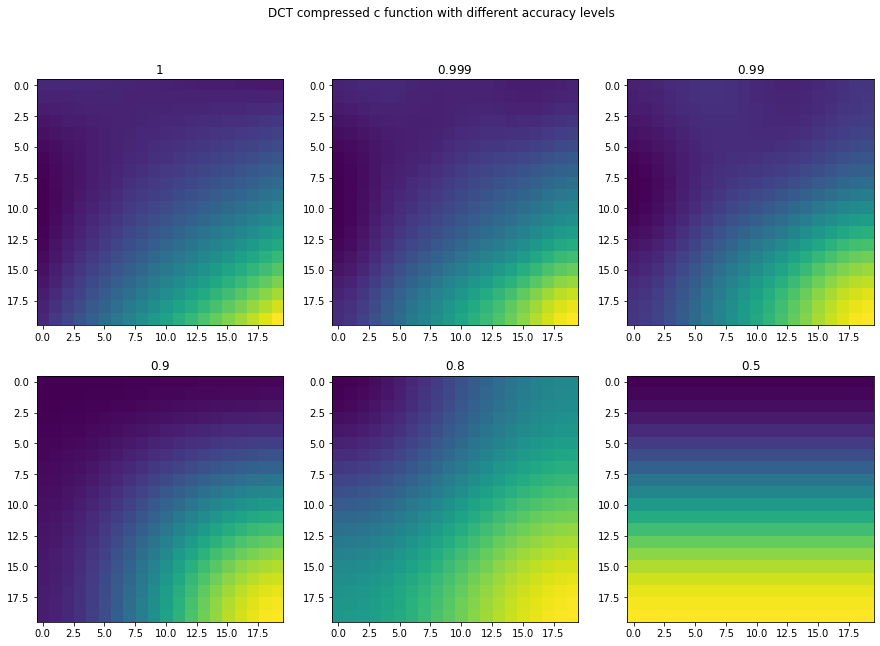

In [9]:
# DCT in 2 dimensions for different levels of accuracy 

fig = plt.figure(figsize=(15,10))
fig.suptitle('DCT compressed c function with different accuracy levels')
lvl_lst = np.array([0.999,0.99,0.9,0.8,0.5])
ax=fig.add_subplot(2,3,1)
ax.imshow(c2d)
ax.set_title(r'$1$')

for idx in range(len(lvl_lst)):
    i = 1    
    while lag.norm(c2d_dct_flt[ind2d[:i]].copy())/lag.norm(c2d_dct_flt) < lvl_lst[idx]:
        i += 1    
    needed = i
    print("For accuracy level of "+str(lvl_lst[idx])+", "+str(needed)+" basis functions are used")
    c2d_dct_rdc=c2d_dct.copy()
    idx_urv = np.unravel_index(np.sort(ind2d[needed+1:]),(grid0,grid1),order='F')
    c2d_dct_rdc[idx_urv] = 0
    c2d_approx = idct2d(c2d_dct_rdc)
    ax = fig.add_subplot(2,3,idx+2)
    ax.set_title(r'${}$'.format(lvl_lst[idx]))
    ax.imshow(c2d_approx)

For accuracy level of 0.999, 10 basis functions are used
For accuracy level of 0.99, 5 basis functions are used
For accuracy level of 0.9, 3 basis functions are used
For accuracy level of 0.8, 2 basis functions are used
For accuracy level of 0.5, 1 basis functions are used


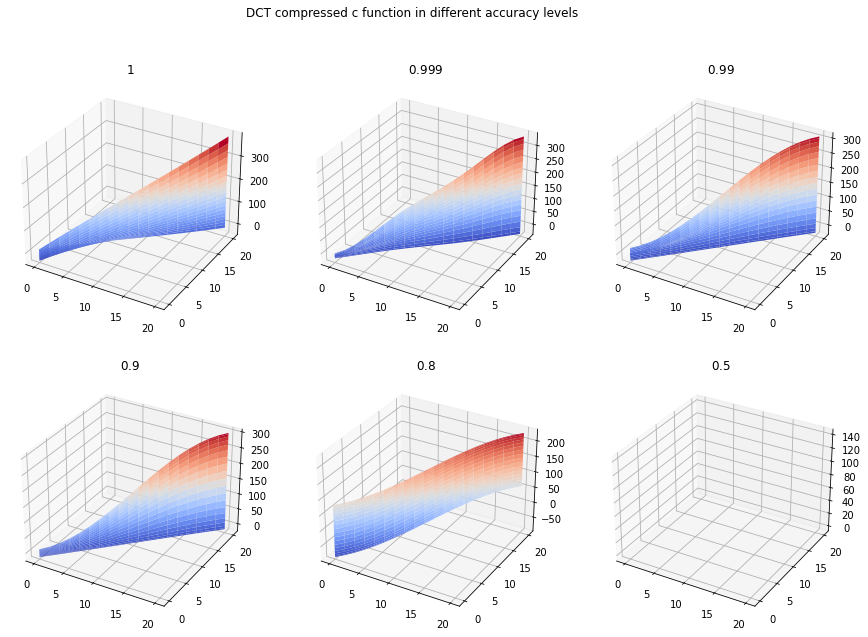

In [10]:
## surface plot of c at full grids and dct approximates with different accuracy levels

fig = plt.figure(figsize=(15,10))
fig.suptitle('DCT compressed c function in different accuracy levels')
lvl_lst = np.array([0.999,0.99,0.9,0.8,0.5])
ax=fig.add_subplot(2,3,1,projection='3d')
ax.plot_surface(grids0,grids1,c2d,cmap=cm.coolwarm)
ax.set_title(r'$1$')

for idx in range(len(lvl_lst)):
    i = 1    
    while lag.norm(c2d_dct_flt[ind2d[:i]].copy())/lag.norm(c2d_dct_flt) < lvl_lst[idx]:
        i += 1    
    needed = i
    print("For accuracy level of "+str(lvl_lst[idx])+", "+str(needed)+" basis functions are used")
    c2d_dct_rdc=c2d_dct.copy()
    idx_urv = np.unravel_index(ind2d[needed+1:],(grid0,grid1))
    c2d_dct_rdc[idx_urv] = 0
    c2d_approx = idct2d(c2d_dct_rdc)
    ax = fig.add_subplot(2,3,idx+2,projection='3d')
    ax.set_title(r'${}$'.format(lvl_lst[idx]))
    ax.plot_surface(grids0,grids1,c2d_approx,cmap=cm.coolwarm)

For accuracy level of 0.999, 10 basis functions are used
For accuracy level of 0.99, 5 basis functions are used
For accuracy level of 0.9, 3 basis functions are used
For accuracy level of 0.8, 2 basis functions are used
For accuracy level of 0.5, 1 basis functions are used


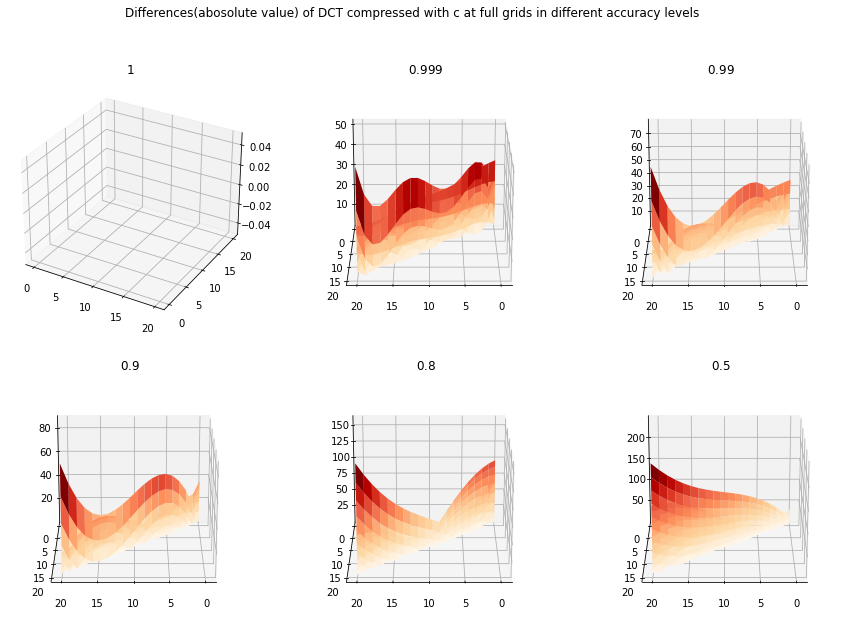

In [11]:
# surface plot of absoulte value of differences of c at full grids and approximated

fig = plt.figure(figsize=(15,10))
fig.suptitle('Differences(abosolute value) of DCT compressed with c at full grids in different accuracy levels')
lvl_lst = np.array([0.999,0.99,0.9,0.8,0.5])
ax=fig.add_subplot(2,3,1,projection='3d')
c2d_diff = abs(c2d-c2d)
ax.plot_surface(grids0,grids1,c2d_diff,cmap=cm.coolwarm)
ax.set_title(r'$1$')
for idx in range(len(lvl_lst)):
    i = 1    
    while lag.norm(c2d_dct_flt[ind2d[:i]].copy())/lag.norm(c2d_dct_flt) < lvl_lst[idx]:
        i += 1    
    needed = i
    print("For accuracy level of "+str(lvl_lst[idx])+", "+str(needed)+" basis functions are used")
    c2d_dct_rdc=c2d_dct.copy()
    idx_urv = np.unravel_index(ind2d[needed+1:],(grid0,grid1))
    c2d_dct_rdc[idx_urv] = 0
    c2d_approx = idct2d(c2d_dct_rdc)
    c2d_approx_diff = abs(c2d_approx - c2d)
    ax = fig.add_subplot(2,3,idx+2,projection='3d')
    ax.set_title(r'${}$'.format(lvl_lst[idx]))
    ax.plot_surface(grids0,grids1,c2d_approx_diff,cmap= 'OrRd',linewidth=1)
    ax.view_init(20, 90)